In [1]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 35.2 MB/s eta 0:00:00


In [2]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 7.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


def usable_ace(hand):
    """Verifica si un As puede usarse como 11 sin que la mano supere 21."""
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    """Calcula el total de la mano, considerando el valor del As."""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


class BlackjackEnv(gym.Env):
    """
    Entorno personalizado de Blackjack basado en Gymnasium.

    Simula un entorno de Blackjack con reglas específicas y soporte
    para conteo de cartas utilizando el método Hi-Lo.
    """
    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Inicialización de variables de estado y parámetros del entorno
        self.true_count = 0             # Conteo verdadero basado en cartas vistas
        self.running_count = 0          # Conteo acumulado de cartas según Hi-Lo
        self.deck = []                  # Mazo de cartas
        self.step_count = 0             # Contador de pasos por ronda
        self.max_steps = 100            # Máximo de pasos por ronda
        self.round_over = False         # Estado de la ronda actual
        self.first_move = True          # Indica si es el primer movimiento de la ronda
        self.cut_card_position = None   # Posición de la carta de corte en el mazo
        self.cut_card_reached = False   # Estado de la carta de corte alcanzada
        self.log = []                   # Registro de eventos del entorno

        # Configuración de apuestas
        self.bet_levels = [10, 20, 30]          # Opciones de apuesta
        self.current_bet = self.bet_levels[0]   # Apuesta actual
        self.min_bet = self.bet_levels[0]       # Apuesta mínima
        self.max_bet = self.bet_levels[-1]      # Apuesta máxima
        self.next_bet = self.bet_levels[0]      # Apuesta para la próxima ronda

        # Espacios de acción y observación
        self.action_space = spaces.Discrete(3)  # Acciones: plantarse, pedir, doblar
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -10, 0]),
            high=np.array([32, 11, 10, 1]),
            dtype=np.float32,
        )

        # Barajar el mazo inicial
        self.shuffle_deck()

    def shuffle_deck(self):
        """Barajar el mazo y reiniciar el conteo."""
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 8 * 4
        np.random.shuffle(self.deck)

        # Establecer la posición de la carta de corte entre el 50% y el 65% del mazo
        deck_size = len(self.deck)
        self.cut_card_position = np.random.randint(int(deck_size * 0.5), int(deck_size * 0.65))
        self.log.append(f"[DEBUG] Posición de la carta de corte establecida: {self.cut_card_position}")
        self.cut_card_reached = False

        # Reiniciar conteo y log
        self.running_count = 0
        self.true_count = 0
        self.log = []
        self.log.append("[SHUFFLE] Mazo barajado, conteo reiniciado.")

    def draw_card(self):
        """Robar una carta del mazo y verificar la carta de corte."""
        card = self.deck.pop()

        # Verificar si alcanzamos la carta de corte
        if len(self.deck) <= self.cut_card_position and not self.cut_card_reached:
            self.cut_card_reached = True
            self.log.append(f"[CUT CARD] Se alcanzó la carta de corte en posición {len(self.deck)}.")

        # Actualizar el conteo de cartas
        self.update_running_count([card])

        self.log.append(f"[DRAW CARD] Carta robada: {card}")
        return card


    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno para una nueva ronda.
        """
        if seed is not None:
            np.random.seed(seed)

        if self.cut_card_reached:
            self.log.append("[RESET] Barajando el mazo después de alcanzar la carta de corte.")
            self.shuffle_deck()
            self.cut_card_reached = False

        # Reinicia todos los parámetros de la ronda
        self.round_over = False
        self.step_count = 0
        self.first_move = True

        # Reparto inicial de cartas
        self.player_cards = [self.draw_card(), self.draw_card()]
        self.player_sum = sum_hand(self.player_cards)
        self.dealer_card = self.draw_card()
        self.dealer_cards = [self.dealer_card]

        self.player_blackjack = self._is_blackjack(self.player_cards)
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)
        self.current_bet = self.next_bet

        self.log.append(f"[RESET] Mano del jugador: {self.player_cards}, Carta del dealer: {self.dealer_card}")
        return self._get_obs(), {}

    def _is_blackjack(self, hand):
        """Determina si la mano tiene un Blackjack."""
        return len(hand) == 2 and sum_hand(hand) == 21

    def dealer_play(self):
        """Lógica para el turno del dealer."""
        # El dealer roba su carta 2 al inicio de su turno
        self.dealer_hidden_card = self.draw_card()
        self.dealer_cards.append(self.dealer_hidden_card)
        self.log.append(f"[DEALER] Carta 2 del dealer: {self.dealer_hidden_card}")
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)

        if not self._is_blackjack(self.dealer_cards) and not self._is_blackjack(self.player_cards):
            while sum_hand(self.dealer_cards) < 17:
                card = self.draw_card()
                self.dealer_cards.append(card)

        self.log.append(f"[DEALER] Cartas del dealer: {self.dealer_cards}")

    def step(self, action):
        """Realiza una acción del jugador."""
        reward = 0
        terminated = False
        truncated = False

        # Incrementar contador de pasos
        self.step_count += 1
        if self.step_count > self.max_steps:
            truncated = True
            reward = -self.current_bet
            return self._get_obs(), reward, terminated, truncated, {}

        # Evaluar si el jugador tiene Blackjack
        if self.player_blackjack:
            self.round_over = True
            self.log.append("[PLAYER] Blackjack detectado, paso al dealer.")
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Acciones del jugador
        if action == 0:  # Stand
            self.log.append("[ACTION] Stand")
            self.round_over = True
        elif action == 1:  # Hit
            self.log.append("[ACTION] Hit")
            card = self.draw_card()
            self.player_cards.append(card)
            self.player_sum = sum_hand(self.player_cards)
            self.first_move = False
            self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")

            # Si el jugador alcanza o supera 21, finaliza su turno
            if self.player_sum >= 21:
                self.log.append("[PLAYER] Mano alcanza o supera 21, turno finalizado.")
                self.round_over = True
        elif action == 2:  # Double
            self.log.append("[ACTION] Double")
            if self.first_move:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.current_bet = self.current_bet * 2
                self.first_move = False
                self.round_over = True
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}, Apuesta actual: {self.current_bet}")
            else:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.first_move = False
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")
                if self.player_sum >= 21:
                    self.round_over = True

        # Si el jugador se pasa, dealer gana automáticamente
        if self.player_sum > 21:
            self.log.append("[PLAYER] Mano se pasa de 21, dealer gana automáticamente.")
            reward = -self.current_bet
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Si la ronda ha terminado
        if self.round_over:
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True

        return self._get_obs(), reward, terminated, truncated, {}

    def adjust_bet(self):
        """Ajusta la apuesta para la próxima ronda según el true count."""
        if self.true_count < 1:
            self.next_bet = self.bet_levels[0]
        elif 1 <= self.true_count < 3:
            self.next_bet = self.bet_levels[1]
        else: # self.true_count > 3:
            self.next_bet = self.bet_levels[2]
        self.log.append(f"[ADJUST BET] Nueva apuesta establecida: {self.next_bet}")

    def update_running_count(self, cards):
        """Actualizar el conteo de cartas vistas."""
        hilo_values = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
        for card in cards:
            self.running_count += hilo_values.get(card, 0)

    def calculate_true_count(self):
        """Calcular el true count basado en el conteo actual y el mazo restante según el método Hi-Lo."""
        remaining_decks = len(self.deck) / 52
        if remaining_decks > 0:
            self.true_count = self.running_count / (remaining_decks * 2)
        else:
            self.true_count = 0
        self.log.append(f"[TRUE COUNT] Remaining decks: {remaining_decks}, Running count: {self.running_count}, True count: {self.true_count}")


    def _get_obs(self):
        """Devuelve la observación actual."""
        has_usable_ace = 1 if usable_ace(self.player_cards) else 0
        return np.array([self.player_sum, self.dealer_card, self.true_count, has_usable_ace], dtype=np.float32)

    def _calculate_reward(self):
        """Calcula el resultado de la ronda."""
        # Recompensas específicas para Blackjack
        if self.player_blackjack:
            if self.dealer_blackjack:
                return 0  # Empate
            else:
                return self.current_bet * 1.5  # Ganancia por Blackjack
        elif self.dealer_blackjack:
            return -self.current_bet  # Dealer gana con Blackjack

        # Recompensas estándar
        if self.player_sum > 21:
            return -self.current_bet
        elif sum_hand(self.dealer_cards) > 21 or self.player_sum > sum_hand(self.dealer_cards):
            return self.current_bet
        elif self.player_sum < sum_hand(self.dealer_cards):
            return -self.current_bet
        return 0


In [6]:
env = BlackjackEnv()
for _ in range(300):  # Robar muchas cartas
    card = env.draw_card()
    if env.cut_card_reached:
        print(f"Carta de corte alcanzada en posición {len(env.deck)}")
        break

Carta de corte alcanzada en posición 251


In [7]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import optuna
from stable_baselines3.common.evaluation import evaluate_policy

def optimize_ppo(trial):
    # Definir los hiperparámetros que serán optimizados
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    n_steps = trial.suggest_int("n_steps", 1024, 4096, step=512)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    gamma = trial.suggest_uniform("gamma", 0.9, 0.9999)

    # Crear un entorno vectorizado
    vec_env = DummyVecEnv([lambda: BlackjackEnv()])

    # Crear un modelo PPO con los parámetros seleccionados
    model = PPO(
        policy="MlpPolicy",
        env=vec_env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gamma=gamma,
        verbose=0
    )

    # Configurar un callback para evaluación
    eval_callback = EvalCallback(
        vec_env, best_model_save_path="./logs/",
        log_path="./logs/", eval_freq=500,
        deterministic=True, render=False
    )

    # Entrenar el modelo con un número limitado de timesteps
    model.learn(total_timesteps=20000, callback=eval_callback)

    # Evaluar el modelo final
    mean_reward, _ = evaluate_policy(model, vec_env, n_eval_episodes=10)
    return mean_reward

# Optimizar usando Optuna
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=50)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(study.best_params)


[I 2025-01-25 10:30:10,287] A new study created in memory with name: no-name-1516ab22-7b61-44cd-b112-9a150b7c9cac
<ipython-input-8-13cb277cc878>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
<ipython-input-8-13cb277cc878>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.9, 0.9999)
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environmen

Eval num_timesteps=500, episode_reward=-10.00 +/- 0.00
Episode length: 2.20 +/- 1.47
New best mean reward!
Eval num_timesteps=1000, episode_reward=-12.00 +/- 4.00
Episode length: 2.40 +/- 1.20
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-12.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-3.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=6.00 +/- 16.25
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5500, episode_reward=5.00 +/- 8.94
Episod

[I 2025-01-25 10:30:49,243] Trial 0 finished with value: -3.0 and parameters: {'learning_rate': 0.00012186788745451393, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9034866470854241}. Best is trial 0 with value: -3.0.
<ipython-input-8-13cb277cc878>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
<ipython-input-8-13cb277cc878>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.9, 0.9999)


Eval num_timesteps=500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-9.00 +/- 14.28
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-3.00 +/- 17.20
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-8.00 +/- 11.66
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-10.00 +/- 15.49
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=6.00 +/- 20.59
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-4.00 +/- 16.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=4.00 +/- 13.19
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-2.00 +/- 9.80
E

[I 2025-01-25 10:31:32,745] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.00047711071357879885, 'n_steps': 4096, 'batch_size': 32, 'gamma': 0.990858641711227}. Best is trial 1 with value: 1.0.


Eval num_timesteps=500, episode_reward=-7.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=1.00 +/- 13.56
Episode length: 2.20 +/- 1.47
New best mean reward!
Eval num_timesteps=1500, episode_reward=-12.00 +/- 27.13
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-18.00 +/- 13.27
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 18.33
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-20.00 +/- 30.98
Episode length: 1.60 +/- 1.20
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=4.00 +/- 8.00
Episode length: 1.00 

[I 2025-01-25 10:31:56,864] Trial 2 finished with value: -2.0 and parameters: {'learning_rate': 0.0006632216170336652, 'n_steps': 3584, 'batch_size': 256, 'gamma': 0.9811135822379728}. Best is trial 1 with value: 1.0.


Eval num_timesteps=500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval

[I 2025-01-25 10:32:28,766] Trial 3 finished with value: -1.0 and parameters: {'learning_rate': 1.5656950568053155e-05, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9647947876984562}. Best is trial 1 with value: 1.0.


Eval num_timesteps=500, episode_reward=-8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-4.00 +/- 23.32
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-6.00 +/- 17.15
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-9.00 +/- 14.28
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=0.00 +/- 17.89
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-3.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=0.00 +/- 12.25
Episode length: 1.00 +/- 0.00
Eval num_timest

[I 2025-01-25 10:32:50,056] Trial 4 finished with value: 1.5 and parameters: {'learning_rate': 0.0003008536368886655, 'n_steps': 4096, 'batch_size': 256, 'gamma': 0.9535743332734848}. Best is trial 4 with value: 1.5.


Eval num_timesteps=500, episode_reward=-24.00 +/- 32.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 14.97
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-28.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-14.00 +/- 12.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 

[I 2025-01-25 10:33:32,837] Trial 5 finished with value: -0.5 and parameters: {'learning_rate': 9.29675047470827e-05, 'n_steps': 2048, 'batch_size': 32, 'gamma': 0.9970138187001047}. Best is trial 4 with value: 1.5.


Eval num_timesteps=500, episode_reward=-8.00 +/- 4.00
Episode length: 1.60 +/- 0.80
New best mean reward!
Eval num_timesteps=1000, episode_reward=-12.00 +/- 4.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-14.00 +/- 4.90
Episode length: 1.40 +/- 0.49
Eval num_timesteps=2000, episode_reward=-1.00 +/- 11.14
Episode length: 1.60 +/- 1.20
New best mean reward!
Eval num_timesteps=2500, episode_reward=-12.00 +/- 4.00
Episode length: 1.60 +/- 0.49
Eval num_timesteps=3000, episode_reward=-18.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.80
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=4500, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 

[I 2025-01-25 10:33:58,929] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.0003714746459531008, 'n_steps': 3584, 'batch_size': 128, 'gamma': 0.9092198059263978}. Best is trial 4 with value: 1.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 8.00
Episode length: 2.40 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 0.00
Episode length: 1.80 +/- 0.98
Eval num_timesteps=1500, episode_reward=-5.00 +/- 10.00
Episode length: 1.80 +/- 0.75
New best mean reward!
Eval num_timesteps=2000, episode_reward=-3.00 +/- 9.80
Episode length: 1.60 +/- 0.80
New best mean reward!
Eval num_timesteps=2500, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=3000, episode_reward=-14.00 +/- 4.90
Episode length: 1.80 +/- 0.75
Eval num_timesteps=3500, episode_reward=-8.00 +/- 4.00
Episode length: 1.60 +/- 0.80
Eval num_timesteps=4000, episode_reward=-8.00 +/- 14.70
Episode length: 2.00 +/- 0.63
Eval num_timesteps=4500, episode_reward=-1.00 +/- 9.17
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=5000, episode_reward=-4.00 +/- 8.00
Episode length: 1.60 +/- 0.49
Eval num_timesteps=5500, episode_rewa

[I 2025-01-25 10:34:20,953] Trial 7 finished with value: -1.0 and parameters: {'learning_rate': 0.0006628511606748224, 'n_steps': 4096, 'batch_size': 256, 'gamma': 0.9021855472445283}. Best is trial 4 with value: 1.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 12.00
Episode length: 1.80 +/- 0.98
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 0.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-10.00 +/- 0.00
Episode length: 2.00 +/- 0.63
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 1.80 +/- 0.75
Eval num_timesteps=2500, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=9.00 +/- 4.90
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-6.00 +/- 4.90
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.

[I 2025-01-25 10:35:03,493] Trial 8 finished with value: 1.0 and parameters: {'learning_rate': 4.6615457463193e-05, 'n_steps': 2048, 'batch_size': 32, 'gamma': 0.9488396725906105}. Best is trial 4 with value: 1.5.


Eval num_timesteps=500, episode_reward=-10.00 +/- 0.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 0.00
Episode length: 1.40 +/- 0.80
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=2000, episode_reward=-8.00 +/- 14.70
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2500, episode_reward=-4.00 +/- 8.00
Episode length: 2.00 +/- 1.10
New best mean reward!
Eval num_timesteps=3000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=8.00 +/- 9.27
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=5.00 +/- 8.94
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5

[I 2025-01-25 10:35:46,879] Trial 9 finished with value: 8.5 and parameters: {'learning_rate': 0.0005892047478194669, 'n_steps': 2560, 'batch_size': 32, 'gamma': 0.9858302533253447}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000,

[I 2025-01-25 10:36:10,817] Trial 10 finished with value: -3.5 and parameters: {'learning_rate': 0.00015043610140318096, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9327814255465972}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-18.00 +/- 4.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1000, episode_reward=-16.00 +/- 4.90
Episode length: 1.80 +/- 0.98
New best mean reward!
Eval num_timesteps=1500, episode_reward=-18.00 +/- 4.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-17.00 +/- 17.78
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-16.00 +/- 4.90
Episode length: 1.60 +/- 0.80
Eval num_timesteps=3500, episode_reward=4.00 +/- 17.44
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-2.00 +/- 9.80

[I 2025-01-25 10:36:34,622] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.0002472183951241405, 'n_steps': 3072, 'batch_size': 256, 'gamma': 0.9670712503726867}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-5.00 +/- 10.00
Episode length: 2.20 +/- 0.98
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 0.00
Episode length: 1.80 +/- 0.98
Eval num_timesteps=1500, episode_reward=-8.00 +/- 4.00
Episode length: 1.80 +/- 0.40
Eval num_timesteps=2000, episode_reward=-10.00 +/- 0.00
Episode length: 1.80 +/- 0.40
Eval num_timesteps=2500, episode_reward=-1.00 +/- 11.14
Episode length: 2.00 +/- 1.26
New best mean reward!
Eval num_timesteps=3000, episode_reward=1.00 +/- 13.56
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=3500, episode_reward=6.00 +/- 8.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=4000, episode_reward=8.00 +/- 4.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.49
Eval num_timesteps=5000, episode_reward=6.00 +/- 8.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5500, episode_reward=

[I 2025-01-25 10:37:17,013] Trial 12 finished with value: -3.5 and parameters: {'learning_rate': 0.00092991189639697, 'n_steps': 2560, 'batch_size': 32, 'gamma': 0.9355157285866466}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=11.00 +/- 15.62
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=7.00 +/- 15.36
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-10.00 +/- 36.88
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
Eval num_timesteps=3500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=12.00 +/- 2.45
Episode length: 1.00 +/- 0.00
New best mean reward

[I 2025-01-25 10:37:38,845] Trial 13 finished with value: -4.0 and parameters: {'learning_rate': 0.00028021500807749836, 'n_steps': 2048, 'batch_size': 256, 'gamma': 0.9717709274862146}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 12.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=2000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=

[I 2025-01-25 10:38:22,975] Trial 14 finished with value: -8.0 and parameters: {'learning_rate': 6.024396459625515e-05, 'n_steps': 3072, 'batch_size': 32, 'gamma': 0.9543217055245274}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=9.00 +/- 14.97
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=4.00 +/- 13.56
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-7.00 +/- 16.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=5.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-10.00

[I 2025-01-25 10:38:45,957] Trial 15 finished with value: -6.0 and parameters: {'learning_rate': 0.00021632673567213042, 'n_steps': 1536, 'batch_size': 256, 'gamma': 0.9230885565893142}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-40.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=0.00 +/- 8.94
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5000, episode_reward=-8.00 +/- 4.00
Episode length: 1.60 +/- 0.49
Eval num_timesteps=5500, episode_reward=11.00 +/- 2.00
Episode length: 1.20 +/- 0.40
New best mean rew

[I 2025-01-25 10:39:12,142] Trial 16 finished with value: -6.0 and parameters: {'learning_rate': 0.0009900731575792, 'n_steps': 3072, 'batch_size': 128, 'gamma': 0.9834170297110764}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=2.00 +/- 11.22
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-10.00 +/- 10.95
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=3.00 +/- 12.49
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-8.00 +/- 4.00
Episod

[I 2025-01-25 10:39:43,550] Trial 17 finished with value: -6.0 and parameters: {'learning_rate': 1.2410431670128187e-05, 'n_steps': 3584, 'batch_size': 64, 'gamma': 0.948875375073313}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-16.00 +/- 4.90
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 10.95
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1500, episode_reward=-10.00 +/- 15.49
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.0

[I 2025-01-25 10:40:06,203] Trial 18 finished with value: 2.5 and parameters: {'learning_rate': 0.0004120389823858832, 'n_steps': 1536, 'batch_size': 256, 'gamma': 0.9571060417062919}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=0.00 +/- 17.89
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2500, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=12.00 +/- 4.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-5.00 +/- 10.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=4000, episode_reward=0.00 +/- 8.94
Episode length: 1.20 +/- 0.40
Eval num_timesteps=4500, episode_reward=0.00 +/- 8.94
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.40 +/- 0.80
Eval num_timesteps=5500, episode_reward=7.00 +/- 6.00
Episode l

[I 2025-01-25 10:40:51,334] Trial 19 finished with value: 2.5 and parameters: {'learning_rate': 0.0004985251325027791, 'n_steps': 1536, 'batch_size': 32, 'gamma': 0.978990279463518}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-16.00 +/- 4.90
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-2.00 +/- 14.70
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-10.00 +/- 6.32
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=0.00 +/- 12.25
Episod

[I 2025-01-25 10:41:14,019] Trial 20 finished with value: 2.5 and parameters: {'learning_rate': 2.8516571404547684e-05, 'n_steps': 1536, 'batch_size': 256, 'gamma': 0.962678743295955}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-7.00 +/- 13.27
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 15.49
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=5.00 +/- 12.65
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=2000, episode_reward=14.00 +/- 3.74
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2500, episode_reward=-4.00 +/- 12.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-6.00 +/- 13.56
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 4.90
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-4.00 +/- 29.39
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-8.00 +/- 7.48
Episode length: 1.00 +/- 

[I 2025-01-25 10:41:59,845] Trial 21 finished with value: 0.0 and parameters: {'learning_rate': 0.000507930619989359, 'n_steps': 1536, 'batch_size': 32, 'gamma': 0.9789937653838376}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-8.00 +/- 24.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-13.00 +/- 14.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-2.00 +/- 9.80
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=2500, episode_reward=2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=3000, episode_reward=6.00 +/- 8.00
Episode length: 1.60 +/- 1.20
New best mean reward!
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-6.00 +/- 8.00
Episode length: 1.60 +/- 0.49
Eval num_timesteps=5500, episode_reward

[I 2025-01-25 10:42:45,548] Trial 22 finished with value: -2.0 and parameters: {'learning_rate': 0.00017719912814629656, 'n_steps': 1536, 'batch_size': 32, 'gamma': 0.9891633444666684}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 13.56
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=2.00 +/- 11.66
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-14.00 +/- 4.90
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-10.00 +/- 15.49
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timest

[I 2025-01-25 10:43:30,872] Trial 23 finished with value: -2.0 and parameters: {'learning_rate': 0.0004109794734220215, 'n_steps': 1024, 'batch_size': 32, 'gamma': 0.9729266747628322}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-2.00 +/- 14.70
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-8.00 +/- 14.70
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-12.00 +/- 7.48
Episode length: 1.40 +/- 0.80
Eval num_timesteps=2500, episode_reward=2.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps

[I 2025-01-25 10:44:16,137] Trial 24 finished with value: -3.0 and parameters: {'learning_rate': 0.0005817405850803018, 'n_steps': 2560, 'batch_size': 32, 'gamma': 0.9986596910621028}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=2.00 +/- 9.80
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=7.00 +/- 14.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-1.00 +/- 9.17
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-3.00 +/- 13.27
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-10.00 +/- 6.32
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 4.90
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6

[I 2025-01-25 10:44:59,900] Trial 25 finished with value: -0.5 and parameters: {'learning_rate': 0.0007764331500346363, 'n_steps': 2048, 'batch_size': 32, 'gamma': 0.9773698703039422}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 13.56
Episode length: 1.60 +/- 0.80
New best mean reward!
Eval num_timesteps=1000, episode_reward=-6.00 +/- 17.44
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-6.00 +/- 13.56
Episode length: 1.60 +/- 0.49
Eval num_timesteps=2000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=1.00 +/- 10.20
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00

[I 2025-01-25 10:45:33,573] Trial 26 finished with value: -0.5 and parameters: {'learning_rate': 0.0003543734011353278, 'n_steps': 1536, 'batch_size': 64, 'gamma': 0.9604409347378412}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-1.00 +/- 11.14
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-2.00 +/- 9.80
Episode length: 1.40 +/- 0.80
Eval num_timesteps=2000, episode_reward=-1.00 +/- 11.14
Episode length: 1.40 +/- 0.80
Eval num_timesteps=2500, episode_reward=-2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-12.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6

[I 2025-01-25 10:45:58,756] Trial 27 finished with value: 4.0 and parameters: {'learning_rate': 9.740779102316799e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9895173247428286}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-2.00 +/- 14.70
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=0.00 +/- 17.89
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-6.00 +/- 13.56
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episo

[I 2025-01-25 10:46:23,847] Trial 28 finished with value: -8.0 and parameters: {'learning_rate': 6.466167821461215e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9882357049926588}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=1.00 +/- 10.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000,

[I 2025-01-25 10:46:48,729] Trial 29 finished with value: 4.0 and parameters: {'learning_rate': 9.988092311850851e-05, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9350133993179551}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-5.00 +/- 10.00
Episode length: 1.60 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 10.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2000, episode_reward=-12.00 +/- 4.00
Episode length: 1.60 +/- 0.80
Eval num_timesteps=2500, episode_reward=-10.00 +/- 10.95
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=1.00 +/- 13.56
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-4.00 +/- 8.00
Epis

[I 2025-01-25 10:47:14,062] Trial 30 finished with value: 1.0 and parameters: {'learning_rate': 0.00010215923114568795, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9409421405250784}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 18.44
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-24.00 +/- 32.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-9.00 +/- 14.28
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-8.00 +/- 24.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=2.00 +/- 7.48
Ep

[I 2025-01-25 10:47:39,864] Trial 31 finished with value: 1.5 and parameters: {'learning_rate': 0.00012352750959778244, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9224105644994525}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000,

[I 2025-01-25 10:48:04,818] Trial 32 finished with value: 2.0 and parameters: {'learning_rate': 7.807728734465757e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9236251024802982}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-10.00 +/- 15.49
Episode length: 1.20 +/- 0.40
Eval num_timesteps=3500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=4.00 +/- 17.44
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=6.00 +/- 8.00


[I 2025-01-25 10:48:31,238] Trial 33 finished with value: -3.0 and parameters: {'learning_rate': 4.7313179669470314e-05, 'n_steps': 3072, 'batch_size': 128, 'gamma': 0.9424647188593668}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New b

[I 2025-01-25 10:48:56,898] Trial 34 finished with value: -2.5 and parameters: {'learning_rate': 0.00017244867991284425, 'n_steps': 1024, 'batch_size': 128, 'gamma': 0.9921306870335572}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-10.00 +/- 0.00
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=-16.00 +/- 4.90
Episode length: 2.00 +/- 0.63
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 2.00 +/- 0.89
New best mean reward!
Eval num_timesteps=2000, episode_reward=-10.00 +/- 0.00
Episode length: 2.00 +/- 0.89
Eval num_timesteps=2500, episode_reward=-10.00 +/- 0.00
Episode length: 1.60 +/- 0.80
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0

[I 2025-01-25 10:49:27,894] Trial 35 finished with value: -2.5 and parameters: {'learning_rate': 0.00013122196829520855, 'n_steps': 2560, 'batch_size': 64, 'gamma': 0.9126302519490005}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=0.00 +/- 17.89
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-4.00 +/- 12.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.0

[I 2025-01-25 10:49:53,437] Trial 36 finished with value: 4.5 and parameters: {'learning_rate': 2.5560953960790708e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9287878563807799}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-1.00 +/- 11.14
Episode length: 1.60 +/- 0.49
New best mean reward!
Eval num_timesteps=1000, episode_reward=-10.00 +/- 0.00
Episode length: 2.00 +/- 0.89
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.49
Eval num_timesteps=2000, episode_reward=-10.00 +/- 0.00
Episode length: 1.80 +/- 0.75
Eval num_timesteps=2500, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=0.00 +/- 12.25
Episode length: 1.00 +/- 0.0

[I 2025-01-25 10:50:18,949] Trial 37 finished with value: -3.0 and parameters: {'learning_rate': 2.1791398070184327e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9297966246614457}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=2500, episode_reward=-10.00 +/- 0.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=4.00 +/- 16.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0

[I 2025-01-25 10:50:44,939] Trial 38 finished with value: 2.5 and parameters: {'learning_rate': 2.87219048523596e-05, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9093921011652893}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 10.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1500, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 17.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=8.00 +/- 19.39
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=14.00 +/- 13.56
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timest

[I 2025-01-25 10:51:10,334] Trial 39 finished with value: -1.5 and parameters: {'learning_rate': 4.006061459455686e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9169473158510038}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=2.00 +/- 11.66
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.0

[I 2025-01-25 10:51:36,475] Trial 40 finished with value: 0.0 and parameters: {'learning_rate': 1.7716026557399788e-05, 'n_steps': 3072, 'batch_size': 128, 'gamma': 0.9428826308204126}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 8.00
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=1000, episode_reward=-8.00 +/- 9.80
Episode length: 1.80 +/- 0.75
Eval num_timesteps=1500, episode_reward=-5.00 +/- 10.00
Episode length: 1.40 +/- 0.49
New best mean reward!
Eval num_timesteps=2000, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.49
Eval num_timesteps=2500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-1.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=2.00 +/- 9.80
Episode 

[I 2025-01-25 10:51:57,872] Trial 41 finished with value: 1.5 and parameters: {'learning_rate': 1.0971879310753352e-05, 'n_steps': 2048, 'batch_size': 256, 'gamma': 0.9288621857821246}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=1.00 +/- 10.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000,

[I 2025-01-25 10:52:22,914] Trial 42 finished with value: 4.0 and parameters: {'learning_rate': 9.116155233541489e-05, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9568677027350543}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6000, epi

[I 2025-01-25 10:52:47,934] Trial 43 finished with value: -1.0 and parameters: {'learning_rate': 8.923708199639684e-05, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9379170346505219}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-6.00 +/- 8.00
Episode length: 2.20 +/- 0.75
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 10.00
Episode length: 1.60 +/- 0.49
New best mean reward!
Eval num_timesteps=1500, episode_reward=-4.00 +/- 8.00
Episode length: 1.80 +/- 0.40
New best mean reward!
Eval num_timesteps=2000, episode_reward=-5.00 +/- 10.00
Episode length: 2.20 +/- 1.47
Eval num_timesteps=2500, episode_reward=-5.00 +/- 10.00
Episode length: 1.40 +/- 0.49
Eval num_timesteps=3000, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 14.35
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_rewar

[I 2025-01-25 10:53:12,595] Trial 44 finished with value: -1.0 and parameters: {'learning_rate': 6.700739335480862e-05, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.9945523604384955}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-8.00 +/- 16.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 18.44
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5500, episode_r

[I 2025-01-25 10:53:39,007] Trial 45 finished with value: -10.0 and parameters: {'learning_rate': 0.00010440037004987027, 'n_steps': 3072, 'batch_size': 128, 'gamma': 0.9863198978197931}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-5.00 +/- 18.44
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=1.00 +/- 17.44
Episode length: 1.40 +/- 0.80
New best mean reward!
Eval num_timesteps=2000, episode_reward=3.00 +/- 18.87
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2500, episode_reward=6.00 +/- 18.55
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=2.00 +/- 11.66
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-1.00 +/- 11.14
Episode 

[I 2025-01-25 10:54:03,959] Trial 46 finished with value: 2.5 and parameters: {'learning_rate': 4.929345175530812e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9683922600916932}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-12.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-12.00 +/- 16.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=22.00 +/- 4.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=0.00 +/- 16.73
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=2.00 +/- 9.80
Ep

[I 2025-01-25 10:54:28,865] Trial 47 finished with value: -0.5 and parameters: {'learning_rate': 0.00020893583316131245, 'n_steps': 2560, 'batch_size': 128, 'gamma': 0.944934568297861}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=-7.00 +/- 13.27
Episode length: 1.40 +/- 0.80
New best mean reward!
Eval num_timesteps=1000, episode_reward=-4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-6.00 +/- 19.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-20.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=3.00 +/- 18.87
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=4.00 +/- 19.60
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=-5.00 +/- 18.44
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
Eval num_timesteps=4500, episode_reward=-6.00 +/- 8.00
Episode length: 1.40 +/- 0.80
Eval num_timesteps=5000, episode_reward=-1.00 +/- 11.14
Episode length: 1.40 +/- 0.49
Eval num_timesteps=5500, episode_reward=3.00 +/- 10.77
Ep

[I 2025-01-25 10:55:00,623] Trial 48 finished with value: 0.5 and parameters: {'learning_rate': 0.00014858341622123734, 'n_steps': 3584, 'batch_size': 64, 'gamma': 0.9331165840824287}. Best is trial 9 with value: 8.5.


Eval num_timesteps=500, episode_reward=0.00 +/- 16.73
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-24.00 +/- 23.32
Episode length: 1.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=0.00 +/- 14.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-12.00 +/- 29.93
Episode length: 1.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3500, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4500, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.0

[I 2025-01-25 10:55:25,135] Trial 49 finished with value: 0.0 and parameters: {'learning_rate': 8.505936011154604e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9837300452401986}. Best is trial 9 with value: 8.5.


Mejores parámetros encontrados:
{'learning_rate': 0.0005892047478194669, 'n_steps': 2560, 'batch_size': 32, 'gamma': 0.9858302533253447}


In [9]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# Crear el entorno de evaluación
eval_env = DummyVecEnv([lambda: BlackjackEnv()])

# Configurar el callback de evaluación
eval_callback = EvalCallback(
    eval_env,                          # Entorno de evaluación
    best_model_save_path="./logs/",    # Carpeta para guardar el mejor modelo
    log_path="./logs/",                # Carpeta para guardar las evaluaciones
    eval_freq=5000,                    # Frecuencia de evaluación (en timesteps)
    n_eval_episodes=10,                # Número de episodios por evaluación
    deterministic=True,                # Política determinista
    render=False                       # No renderizar durante la evaluación
)

# Crear el entorno principal
train_env = DummyVecEnv([lambda: BlackjackEnv()])

# Configurar el modelo PPO
model = PPO(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=0.0005892047478194669,
    n_steps=2560,
    batch_size=32,
    n_epochs=10,
    gamma=0.9858302533253447,
    verbose=1
)

# Entrenar el modelo con el callback de evaluación
model.learn(total_timesteps=500000, callback=eval_callback)

# Guardar el modelo
model.save("ppo_blackjack")



Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1075 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2560 |
-----------------------------
Eval num_timesteps=5000, episode_reward=2.00 +/- 9.80
Episode length: 1.10 +/- 0.30
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.1        |
|    mean_reward          | 2          |
| time/                   |            |
|    total_timesteps      | 5000       |
| train/                  |            |
|    approx_kl            | 0.01082515 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.000221   |
|    learning_rate        | 0.000589   |
|    loss                 | 117        |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0255    |
|    value_loss           | 184  

In [10]:
# Descargar el modelo
from google.colab import files
files.download('ppo_blackjack.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import shutil
from google.colab import files

# Comprimir la carpeta de logs
shutil.make_archive("ppo_logs", "zip", "./logs")

# Descargar el archivo comprimido
files.download("ppo_logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

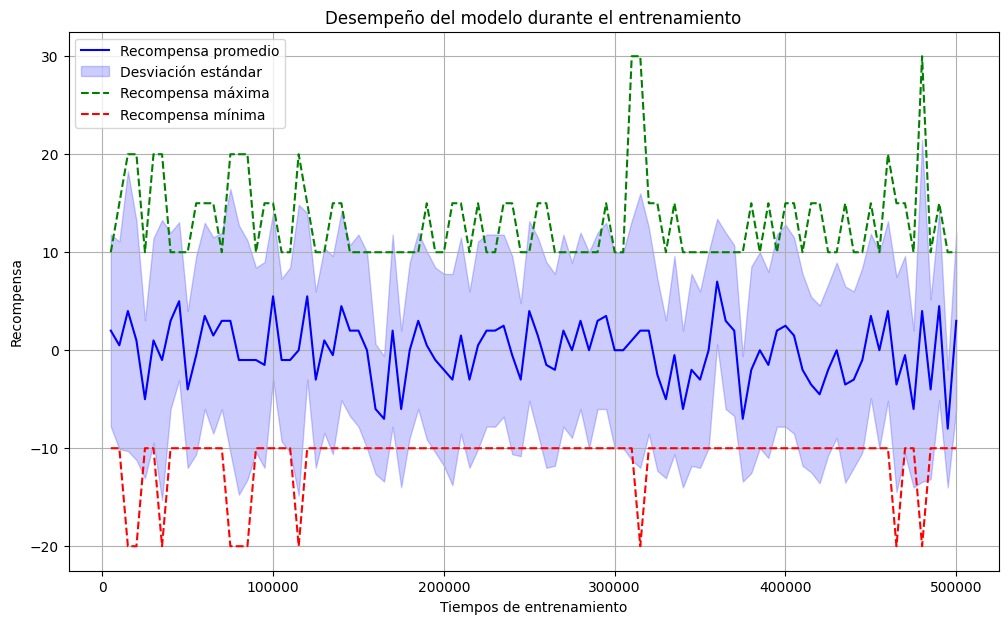

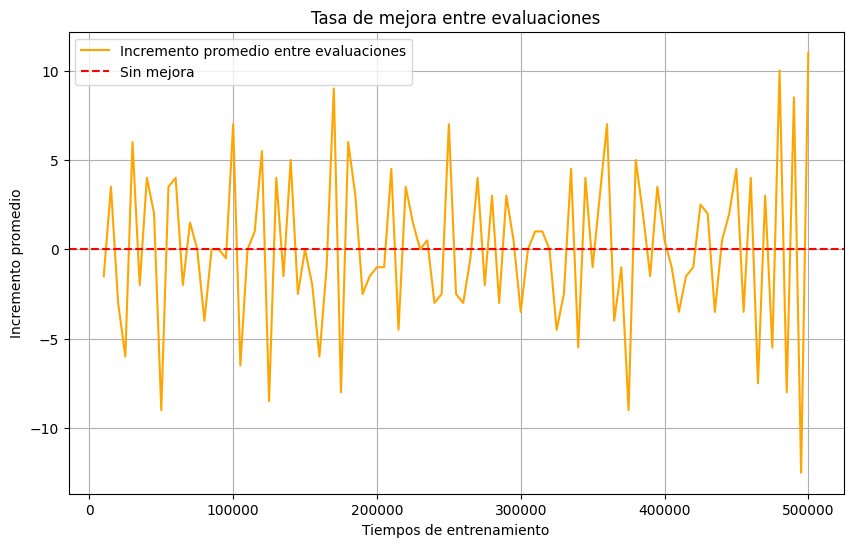

Estabilidad de las últimas recompensas (desviación estándar): 4.31
Porcentaje de evaluaciones con recompensa promedio > 0.8: 42.00%
El mejor modelo se obtuvo en el timestep 360000 con una recompensa promedio de 7.00


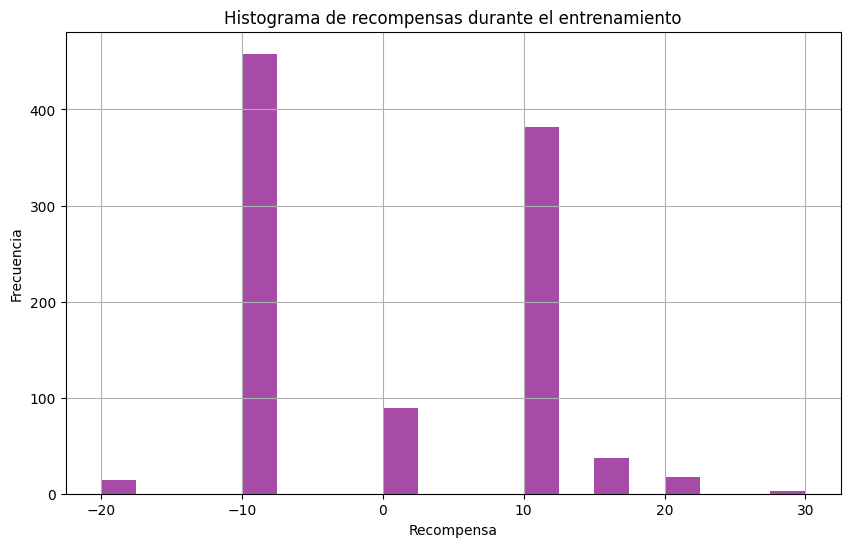

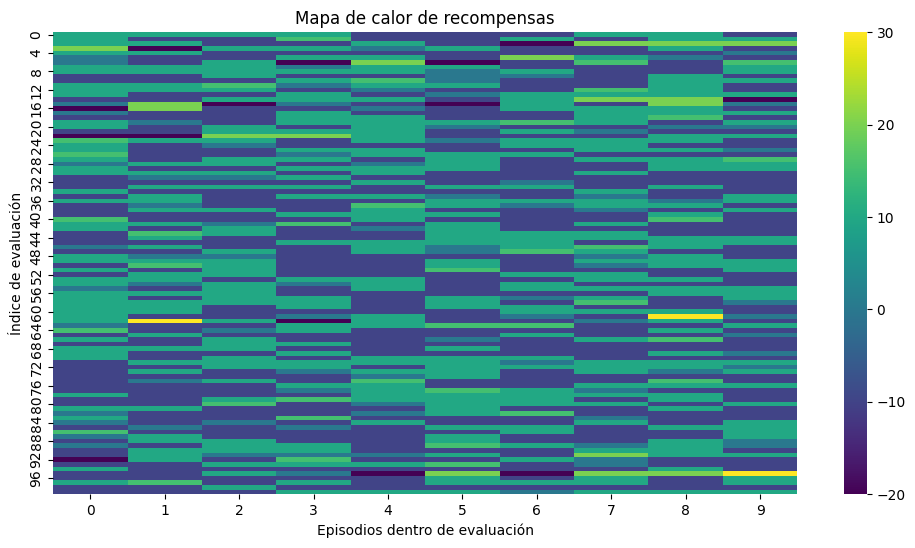

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos del archivo de evaluaciones
log_path = "./logs/evaluations.npz"
data = np.load(log_path)

# Extraer información relevante
timesteps = data["timesteps"]
mean_rewards = data["results"].mean(axis=1)
std_rewards = data["results"].std(axis=1)
max_rewards = data["results"].max(axis=1)
min_rewards = data["results"].min(axis=1)

# Graficar el desempeño del modelo con promedio, desviación estándar, máximo y mínimo
plt.figure(figsize=(12, 7))
plt.plot(timesteps, mean_rewards, label="Recompensa promedio", color="b")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.2,
    label="Desviación estándar",
    color="b"
)
plt.plot(timesteps, max_rewards, label="Recompensa máxima", linestyle="--", color="g")
plt.plot(timesteps, min_rewards, label="Recompensa mínima", linestyle="--", color="r")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Recompensa")
plt.title("Desempeño del modelo durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

# Tasa de mejora promedio entre evaluaciones
mean_diff = np.diff(mean_rewards)
plt.figure(figsize=(10, 6))
plt.plot(timesteps[1:], mean_diff, label="Incremento promedio entre evaluaciones", color="orange")
plt.axhline(0, color="red", linestyle="--", label="Sin mejora")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Incremento promedio")
plt.title("Tasa de mejora entre evaluaciones")
plt.legend()
plt.grid()
plt.show()

# Estabilidad en las últimas evaluaciones
last_rewards = data["results"][-10:]
last_variance = np.std(mean_rewards[-10:])
print(f"Estabilidad de las últimas recompensas (desviación estándar): {last_variance:.2f}")

# Porcentaje de evaluaciones que superan un umbral de recompensa
threshold = 0.8
above_threshold = np.sum(mean_rewards > threshold) / len(mean_rewards) * 100
print(f"Porcentaje de evaluaciones con recompensa promedio > {threshold}: {above_threshold:.2f}%")

# Identificar el mejor modelo y cuándo se obtuvo
best_eval_idx = np.argmax(mean_rewards)
best_timestep = timesteps[best_eval_idx]
best_mean_reward = mean_rewards[best_eval_idx]
print(f"El mejor modelo se obtuvo en el timestep {best_timestep} con una recompensa promedio de {best_mean_reward:.2f}")

# Histograma de recompensas
all_rewards = data["results"].flatten()
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=20, alpha=0.7, color="purple")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.title("Histograma de recompensas durante el entrenamiento")
plt.grid()
plt.show()

# Mapa de calor de recompensas
plt.figure(figsize=(12, 6))
sns.heatmap(data["results"], cmap="viridis", cbar=True)
plt.xlabel("Episodios dentro de evaluación")
plt.ylabel("Índice de evaluación")
plt.title("Mapa de calor de recompensas")
plt.show()

In [ ]:
# Subir archivo a Colab
from google.colab import files

# Subir el archivo
uploaded = files.upload()

# Verificar los archivos subidos
for filename in uploaded.keys():
    print(f"Archivo subido: {filename}")

Saving ppo_blackjack.zip to ppo_blackjack.zip
Archivo subido: ppo_blackjack.zip


In [13]:
from stable_baselines3 import PPO

# Cargar el modelo
model = PPO.load("ppo_blackjack.zip")


Se han truncado las últimas 5000 líneas del flujo de salida.
[TRUE COUNT] Remaining decks: 7.788461538461538, Running count: -2, True count: -0.12839506172839507
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99682 ---
Recompensa total en el episodio 99682: -10
[DRAW CARD] Carta robada: 1
[DRAW CARD] Carta robada: 4
[DRAW CARD] Carta robada: 10
[RESET] Mano del jugador: [1, 4], Carta del dealer: 10
[ACTION] Hit
[DRAW CARD] Carta robada: 8
[PLAYER] Carta añadida: 8, Mano actual: [1, 4, 8]
[ACTION] Hit
[DRAW CARD] Carta robada: 10
[PLAYER] Carta añadida: 10, Mano actual: [1, 4, 8, 10]
[PLAYER] Mano alcanza o supera 21, turno finalizado.
[PLAYER] Mano se pasa de 21, dealer gana automáticamente.
[TRUE COUNT] Remaining decks: 7.6923076923076925, Running count: -4, True count: -0.26
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99683 ---
Recompensa total en el episodio 99683: 10
[DRAW CARD] Carta robada: 10
[DRAW CARD] Carta robada: 7
[DRAW CARD] Carta robada: 4
[RESET] 

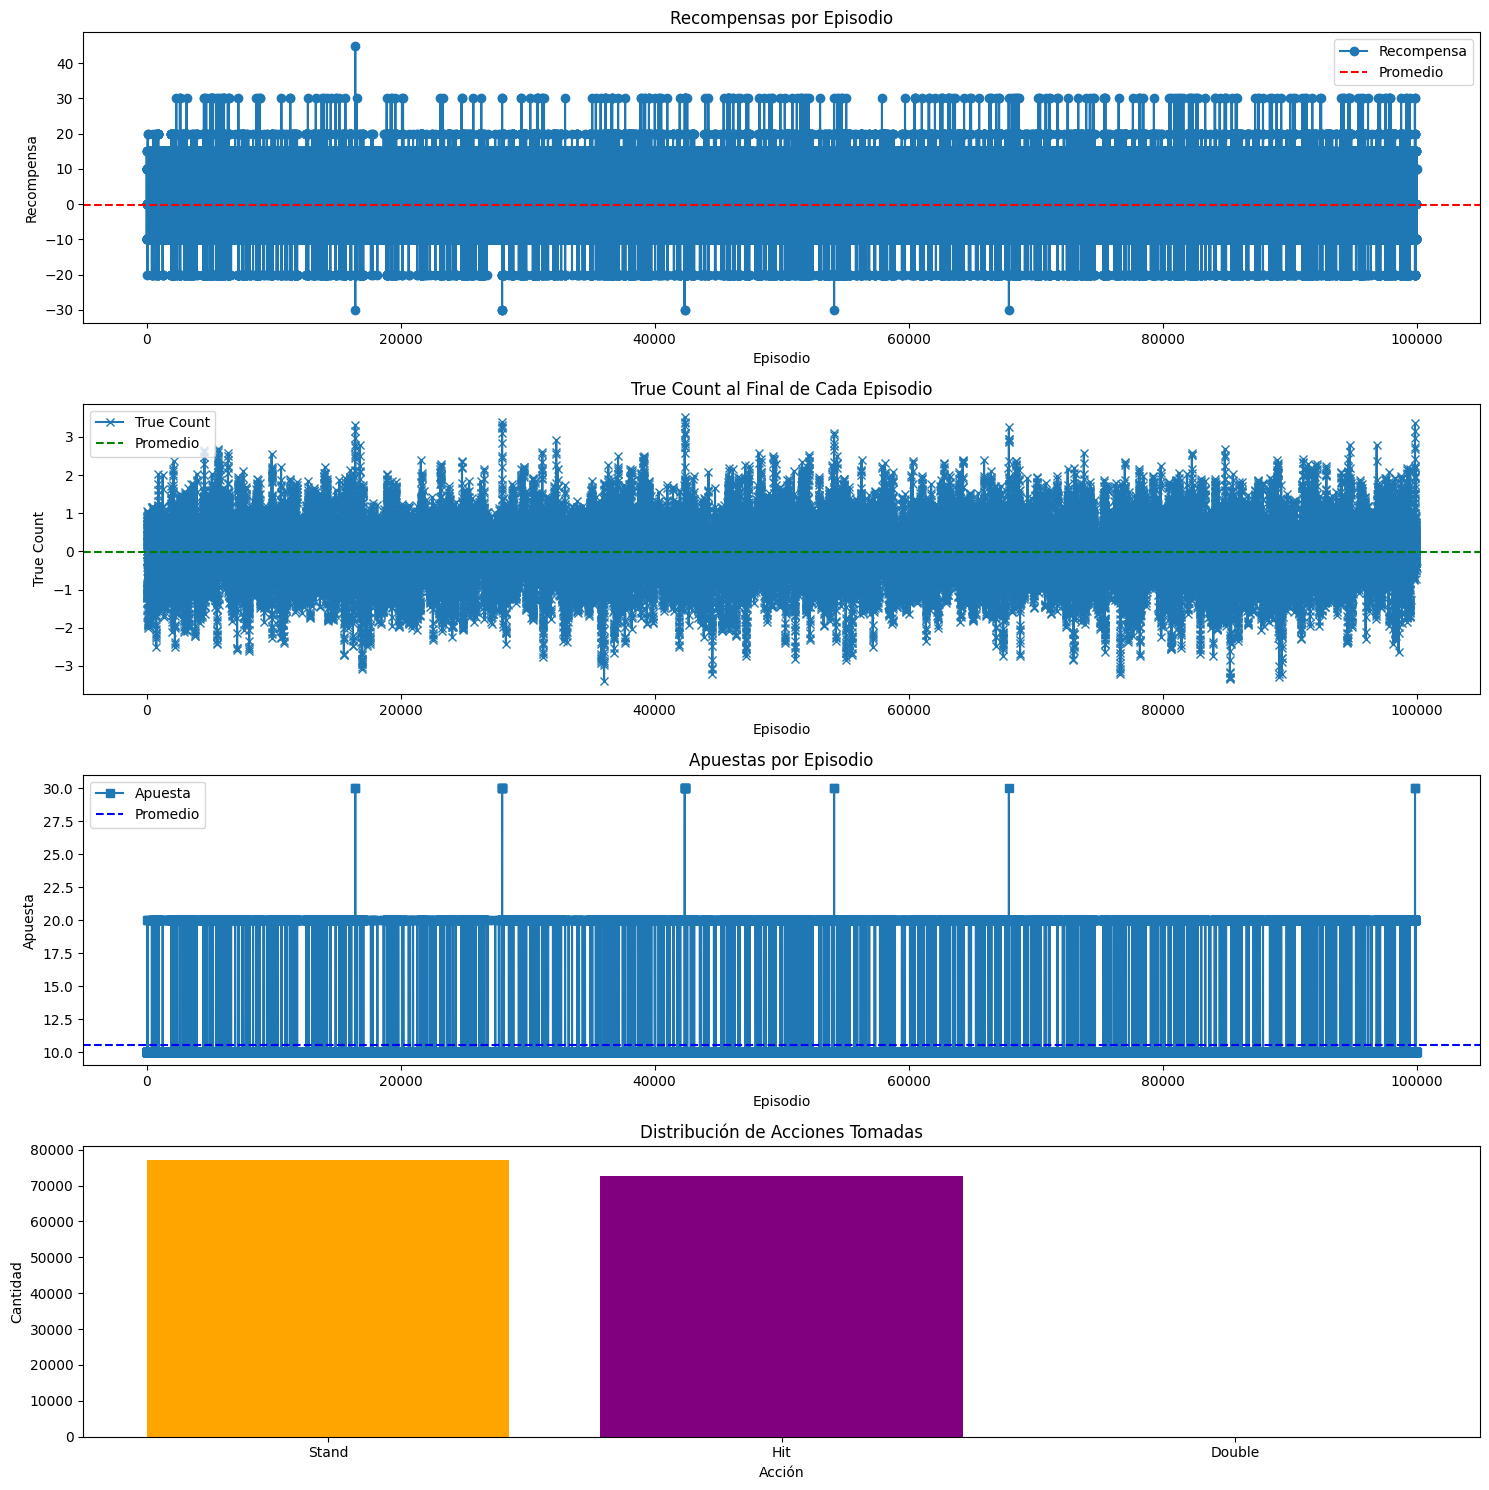

In [33]:
from collections import Counter
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
model = PPO.load("ppo_blackjack.zip")

# Evaluar el modelo y registrar métricas
num_episodes = 100000
rewards = []       # Lista para recompensas por episodio
true_counts = []   # Lista para True Count al final de cada episodio
bets = []          # Lista para apuestas por episodio
actions_count = Counter({"Stand": 0, "Hit": 0, "Double": 0})  # Contador de acciones
bust_count = 0     # Contador de veces que el jugador se pasa de 21

obs, _ = env.reset()
for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Registrar la acción tomada
        if action == 0:
            actions_count["Stand"] += 1
        elif action == 1:
            actions_count["Hit"] += 1
        elif action == 2:
            actions_count["Double"] += 1

        # Verificar si el jugador se pasa de 21 usando el estado (obs)
        player_sum = obs[0]  # Asegúrate de que obs[0] representa la suma de la mano del jugador
        if player_sum > 21:
            bust_count += 1

    # Registrar métricas al final del episodio
    rewards.append(total_reward)
    true_counts.append(env.true_count)
    bets.append(env.current_bet)

    # Imprimir log del episodio
    print(f"\n--- Episodio {episode + 1} ---")
    print(f"Recompensa total en el episodio {episode + 1}: {total_reward}")
    for log_entry in env.log:
        print(log_entry)
    env.log = []  # Limpiar el registro para la próxima ronda

# Calcular victorias, derrotas y empates
wins = len([r for r in rewards if r > 0])
losses = len([r for r in rewards if r < 0])
draws = len([r for r in rewards if r == 0])

# Análisis de las métricas
print("\n--- Resumen de resultados ---")
print(f"Episodios totales: {num_episodes}")
print(f"Victorias: {wins} ({(wins / num_episodes) * 100:.2f}%)")
print(f"Derrotas: {losses} ({(losses / num_episodes) * 100:.2f}%)")
print(f"Empates: {draws} ({(draws / num_episodes) * 100:.2f}%)")
print(f"Recompensa total: {sum(rewards):.2f}")
print(f"Recompensa promedio por episodio: {np.mean(rewards):.2f}")
print("\nAcciones tomadas:")
print(f"Stand: {actions_count['Stand']}")
print(f"Hit: {actions_count['Hit']}")
print(f"Double: {actions_count['Double']}")
print(f"Veces que el jugador se pasa de 21: {bust_count}")

# Generar gráficos de métricas
plt.figure(figsize=(15, 15))

# Gráfico 1: Recompensas por episodio
plt.subplot(4, 1, 1)
plt.plot(range(1, num_episodes + 1), rewards, marker='o', linestyle='-', label="Recompensa")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label="Promedio")
plt.title("Recompensas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()

# Gráfico 2: True Count por episodio
plt.subplot(4, 1, 2)
plt.plot(range(1, num_episodes + 1), true_counts, marker='x', linestyle='-', label="True Count")
plt.axhline(y=np.mean(true_counts), color='g', linestyle='--', label="Promedio")
plt.title("True Count al Final de Cada Episodio")
plt.xlabel("Episodio")
plt.ylabel("True Count")
plt.legend()

# Gráfico 3: Apuestas por episodio
plt.subplot(4, 1, 3)
plt.plot(range(1, num_episodes + 1), bets, marker='s', linestyle='-', label="Apuesta")
plt.axhline(y=np.mean(bets), color='b', linestyle='--', label="Promedio")
plt.title("Apuestas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Apuesta")
plt.legend()

# Gráfico 4: Distribución de acciones
plt.subplot(4, 1, 4)
actions_labels = ["Stand", "Hit", "Double"]
actions_values = [actions_count["Stand"], actions_count["Hit"], actions_count["Double"]]
plt.bar(actions_labels, actions_values, color=['orange', 'purple', 'cyan'])
plt.title("Distribución de Acciones Tomadas")
plt.xlabel("Acción")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()